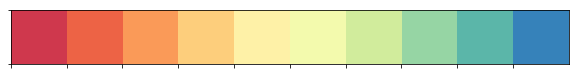

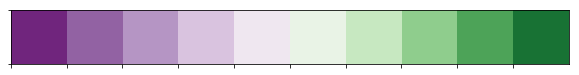

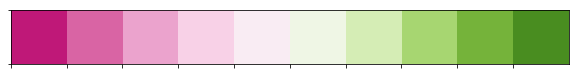

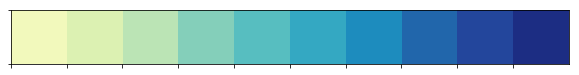

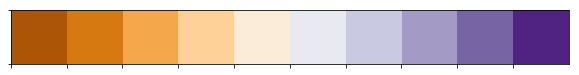

In [1]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
from config import api_key_tmdb
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
import sqlite3
from sqlite3 import Error
import time

In [ ]:
# Function to dynamically scrape IMDB.com
# Returns a dictionary in the form of 
# {"title": [], "genre": [], "imdb_score": [], "meta_score": [], "imdb_id": [], "year": []}
# Such that a DataFrame can be easily constructed
def imdb_url_designer():
    movies = {"title": [], "genre": [], "imdb_score": [], "meta_score": [], "imdb_id": [], "year": []}
    url = None
    for i in range(1, 10000, 50):
        if i < 51:
            url = "https://www.imdb.com/search/title?title_type=movie&genres=action&explore=title_type,genres&ref_=adv_prv"
        if i > 50:
            number = str(i)
            url = "https://www.imdb.com/search/title?title_type=movie&genres=action&start=" + number + "&explore=title_type,genres&ref_=adv_nxt"
        r = requests.get(url)
        if r.status_code == 200:
            c = r.content
            soup = BeautifulSoup(c, 'html.parser')
            movie_articles = soup.find_all("div", class_="lister-item mode-advanced")
            for movie_article in movie_articles:
                # Regular Expression and compiler to extract the 4 digits of a year from the HTML 
                expression = "(\\d+)"
                regex = re.compile(expression, re.IGNORECASE | re.DOTALL)
                match = regex.search(movie_article.find("span", class_="lister-item-year").text)
                if match:
                    movie_year = int(match.group(1))
                    if movie_year <= 2018:
                        movies["year"].append(movie_year) 
                        movie_name = movie_article.find("h3", class_="lister-item-header").a.text
                        movies["title"].append(movie_name)
                        movie_genre = movie_article.find("span", class_="genre").text.strip().replace("/n","").split(",")
                        movies["genre"].append(movie_genre)
                        movie_imdb_id = movie_article.find("div", class_="ribbonize")["data-tconst"]
                        movies["imdb_id"].append(movie_imdb_id)
                        movie_imdb_rating = movie_article.find("div", class_="inline-block ratings-imdb-rating")
                        if movie_imdb_rating:
                            movie_imdb_rating = movie_imdb_rating.text.strip().replace("/n","")
                            movies["imdb_score"].append(movie_imdb_rating) 
                        else:
                            movies["imdb_score"].append(" ")                             
                        movie_meta_rating = movie_article.find("span", class_="metascore ")
                        if movie_meta_rating:
                            movie_meta_rating = movie_meta_rating.text.strip()
                            movies["meta_score"].append(movie_meta_rating)
                        else:
                            movies["meta_score"].append(" ")
        else:
            print(r.status_code)
    return movies

In [ ]:
# Convert the returned dictionary into a Pandas DataFrame
imdb_df = pd.DataFrame.from_dict(movies_dictionary)
# Save DataFrame to csv
imdb_df.to_csv(r"/Users/.../imdb_movies_data.csv")

In [ ]:
# Function to dynamically make API requests to TMDb.org,
# Using the IMDB.com ids, in order to retrieve the movie ids 
# Used by this website to make API requests
# Using the headers recommended by the API documentation
# To prevent from going over the requests limits
# Function does not return anything.
def make_api_requests(movie_ids):
    api_key = {api_key_tmdb}
    for idx, movie in enumerate(movie_ids):
        if movie["tmdb_id"] == None:
            url = "https://api.themoviedb.org/3/find/" + movie["imdb_id"] + "?api_key=" + api_key + "&language=en-US&external_source=imdb_id"
            r = requests.get(url)
            if r.status_code == 200:
                try:
                    # X-RateLimit-Remaining is a header specified in the API documentation
                    # To keep track of requests and not go over the maximum
                    limit_remaining = int(r.headers['X-RateLimit-Remaining'])
                except KeyError as e:
                    print(f"KeyError: {str(e)}")
                    print(f"Response: {r}")
                    print(f"Headers: {r.headers}")
                # X-RateLimit-Reset is a header specified in the API documentation
                # To keep track of how many seconds until the limit resets again    
                reset_time = int(r.headers['X-RateLimit-Reset'])
                result = r.json()
                if result["movie_results"]:
                    print(f"\r{idx}", end = "")
                    movie["tmdb_id"] = result["movie_results"][0]["id"]
                else:
                    print("Result came back empty for id: " + movie["imdb_id"])
            else:
                print(r.status_code)
            while limit_remaining == 2 and reset_time > time.time():
                print("Limit reached, waiting...\r", end = "")
                time.sleep(1)
            print(f"  ", end = "")
            

In [ ]:
# Extract the list of TMDB movie ids.
movie_ids = list(map(lambda imdb_id : {"imdb_id": imdb_id, "tmdb_id": None }, movies_dictionary["imdb_id"]))
make_api_requests(movie_ids)

In [ ]:
# Convert the returned dictionary into a Pandas DataFrame
movie_ids_df = pd.DataFrame.from_dict(movie_ids)
# Save DataFrame to csv
movie_ids_df.to_csv(r"/Users/.../movie_ids.csv")

In [ ]:
# Takes in a dictionary of movie ids, and dynamically
# Makes requests to TMDB API. This is a mutating function
# That transforms a en empty dictionary, into a dictionary
# With information from the movies requested
def make_movie_api_requests(movies_dict):
    api_key = {api_key_tmbd} 
    for idx, m_id in enumerate(movies_dict['id']):
        if movies_dict["title"][idx] == None:
            m_id = str(m_id)
            url = "https://api.themoviedb.org/3/movie/" + m_id + "?api_key=" + api_key + "&language=en-US"
            r = requests.get(url)
            if r.status_code == 200:
                try:
                    # X-RateLimit-Remaining is a header specified in the API documentation
                    # To keep track of requests and not go over the maximum
                    limit_remaining = int(r.headers['X-RateLimit-Remaining'])
                    # X-RateLimit-Reset is a header specified in the API documentation
                    # To keep track of how many seconds until the limit resets again
                    reset_time = int(r.headers['X-RateLimit-Reset'])
                except KeyError as e:
                    print(f"KeyError: {str(e)}")
                    print(f"Response: {r}")
                    print(f"Headers: {r.headers}")
                result = r.json()
                print("\r", idx, end = '')
                if result["title"]:
                    movies_dict["title"][idx] = result["title"]
                else:
                    movies_dict["title"][idx] = result["title"]
                if result["budget"]:
                    movies_dict["budget"].append(result["budget"])
                else:
                    movies_dict["budget"].append(np.nan)

                if result["belongs_to_collection"]:
                    movies_dict["belongs_to_collection"].append(result["belongs_to_collection"]["name"])
                else:
                    movies_dict["belongs_to_collection"].append(np.nan) 

                if result["genres"]:
                    movies_dict["genres"].append(list(map(lambda genre: genre["name"], result["genres"])))
                else:
                    movies_dict["genres"].append(np.nan)

                if result["imdb_id"]:
                    movies_dict["imdb_id"].append(result["imdb_id"])
                else:
                    movies_dict["imdb_id"].append(np.nan)

                if result["overview"]:
                    movies_dict["overview"].append(result["overview"])
                else:
                    movies_dict["overview"].append(np.nan)

                if result["tagline"]:
                    movies_dict["tagline"].append(result["tagline"])
                else:
                    movies_dict["tagline"].append(np.nan)

                if result["runtime"]:
                    movies_dict["runtime"].append(result["runtime"])
                else:
                    movies_dict["runtime"].append(np.nan)

                if result["revenue"]:
                    movies_dict["revenue"].append(result["revenue"])
                else:
                    movies_dict["revenue"].append(np.nan)

                if result["release_date"]:
                    movies_dict["release_date"].append(result["release_date"])
                else:
                    movies_dict["release_date"].append(np.nan)

                if result["production_companies"]:
                    movies_dict["production_companies"].append(result["production_companies"][0]["name"])
                else:
                    movies_dict["production_companies"].append(np.nan)

                if result["vote_count"]:
                    movies_dict["vote_count"].append(result["vote_count"])
                else:
                    movies_dict["vote_count"].append(np.nan)

                if result["vote_average"]:
                    movies_dict["vote_average"].append(result["vote_average"])
                else:
                    movies_dict["vote_average"].append(np.nan)

                if result["popularity"]:
                    movies_dict["popularity"].append(result["popularity"])
                else:
                    movies_dict["popularity"].append(np.nan)
            else:
                print(r.status_code)
            while limit_remaining == 2 and reset_time > time.time():
                    print("Limit reached, waiting...\r", end = "")
                    time.sleep(1)

In [ ]:
# Extract the information of TMDB movies.
tmdb_movies_dict = { "id": tmdb_ids.tolist(), "title": list(map(lambda el: None, tmdb_ids.tolist())), "belongs_to_collection": [], "budget": [], "genres": [], "imdb_id": [], 
           "overview": [], "release_date": [], "revenue": [], "tagline": [], "release_date": [],
           "vote_average": [], "vote_count": [], "runtime": [], "popularity": [], "production_companies": [] }
make_movie_api_requests(tmdb_movies_dict)


In [ ]:
# Convert the returned dictionary into a Pandas DataFrame
tmdb_movies_df = pd.DataFrame.from_dict(tmdb_movies_dict)
# Save DataFrame to csv
tmdb_movies_df.to_csv(r"/Users/.../tmdb_movies_df.csv")

In [ ]:
# Imports the crew csv file
data_two = "/Users/florencialeoni/Documents/flatironDS/Mod1/Blogpost_1/the-movies-dataset/credits.csv"
use_cols_two = ["id", "cast", "crew"]

# Using pandas.read_csv method to load the file
crew_df = pd.read_csv(data_two, usecols = use_cols_two)

# Coerce the "id" column to numeric, drop the null values, and cast it as integer
crew_df["id"] = pd.to_numeric(crew_df["id"], downcast = "integer", errors = "coerce")
crew_df = crew_df.drop(crew_df[crew_df['id'].isnull()].index)
crew_df["id"] = crew_df["id"].astype(int)

# Converted both columns "crew" and "cast" to Abstract Syntax Trees,
# Using Python's ast module and the .literal_eval() function, and
# Applying it through the .apply() method. 
crew_df["crew"] = crew_df["crew"].apply(ast.literal_eval)
crew_df["cast"] = crew_df["cast"].apply(ast.literal_eval)

# Helper function to extract Directors' names from the recently parsed "crew" column
def extract_director(crew_list):
    for member in crew_list:
        if member["department"] == "Directing" and member["job"] == "Director":
            return member["name"]
crew_df["director_name"] = crew_df["crew"].map(extract_director)

# Helper function to extract Directors' genders from the recently parsed "crew" column
def extract_director_gender(crew_list):
    for member in crew_list:
        if member["department"] == "Directing" and member["job"] == "Director":
            return member["gender"]
crew_df["director_gender"] = crew_df["crew"].map(extract_director_gender)

#Helper function to extract Leading Actor from the recently parsed "cast" column
def extract_leading_actor(cast_list):
    for member in cast_list:
        if member["order"] == 0:
            return member["name"]
crew_df["leading_actor_name"] = crew_df["cast"].map(extract_leading_actor)

# Helper function to extract Supporting Actor from the recently parsed "cast" column
def extract_supporting_actor(cast_list):
    for member in cast_list:
        if member["order"] == 1:
            return member["name"]
crew_df["supporting_actor_name"] = crew_df["cast"].map(extract_supporting_actor)

# Drop the original "cast" and "crew" columns since we already have
# The information we needed for the analysis.
crew_df = crew_df.drop(["cast"], axis = 1)
crew_df = crew_df.drop(["crew"], axis = 1)
crew_df

# Merge the main DataFrame with the crew DataFrame 
tmdb_movies_cast_df = pd.merge(tmdb_movies_df, crew_df, how='left', on=["id"])

# Set the "id" column as the Index for the DataFrame
tmdb_movies_cast_df = tmdb_movies_cast_df.set_index("id")

# Save the DataFrame to a csv file
tmdb_movies_cast_df.to_csv(r"/Users/.../tmdb_movies_cast_df.csv")


In [ ]:
# Importing the IMDB movies file
data = "/Users/.../imdb_movies_data.csv"
use_cols = ["imdb_id", "imdb_score", "meta_score"]

# Using pandas.read_csv method to load the file
imdb_df = pd.read_csv(data, usecols = use_cols)
imdb_df = imdb_df.set_index("imdb_id")

# Replace missing data in the "imdb_score" and "meta_score" columns with NumPy NaN values
imdb_df["imdb_score"] = imdb_df["imdb_score"].replace(" ", np.nan)
imdb_df["meta_score"] = imdb_df["meta_score"].replace(" ", np.nan)

# Importing the TMDB Movies file
data = "/Users/.../tmdb_movies_cast_df.csv"

# Using pandas.read_csv method to load the file
tmdb_df = pd.read_csv(data, lineterminator='\n')
tmdb_df = tmdb_df.set_index("id")
tmdb_df = tmdb_df.merge(imdb_df, how = "left", on = "imdb_id")

# Using pandas.to_numeric to coerce the "id", "budget" and "revenue" columns into numbers
tmdb_df["budget"] = pd.to_numeric(tmdb_df["budget"], downcast = "integer", errors = "coerce")
tmdb_df["revenue"] = pd.to_numeric(tmdb_df["revenue"], downcast = "integer", errors = "coerce")

# Lambda function to strip and split "release_date" string values
f = lambda x: str(x).strip().split('-')[0] if x != np.nan else np.nan

# Creating a new column, "year", and assigninf the value of "release_date" 
# After applying the lambda function through map
tmdb_df["year"] = tmdb_df["release_date"].map(f)

# Coerce the "year" column to integers
tmdb_df["year"] = pd.to_numeric(tmdb_df["year"], errors = "coerce")

# Convert "release_date" column to datetime format
tmdb_df["release_date"] = pd.to_datetime(tmdb_df["release_date"])

# Divide "release_date" column in months
tmdb_df["month_of_year"] = tmdb_df["release_date"].dt.month_name()

# Divide "release_date" column in months
tmdb_df["day_of_week"] = tmdb_df["release_date"].dt.day_name()

# Create a subset of the main DataFrame focused on genres
genres_df = tmdb_df[tmdb_df["genres"].notnull()][["title","budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", "genres"]]

# Unpack the values in the genre column using the ast module
genres_df["genres"] = genres_df["genres"].apply(ast.literal_eval)

# Add a column to account for each genre of each movie to the genres_df subset
genres = genres_df["genres"]
genres = genres.apply(pd.Series)
genres = genres.rename(columns = lambda x : 'genre_' + str(x))
genres_df = pd.concat([genres_df[:], genres[:]], axis=1)

# Drop the release date column as we have extracted its information
tmdb_df = tmdb_df.drop(["release_date"], axis=1)

# Create a subset of the main DataFrame focused on the revenue
tmdb_df_revenue = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", 
                            "production_companies", "director_name", "leading_actor_name"]]

# Drop columns for which budget is a null value
tmdb_df_revenue = tmdb_df_revenue.dropna(subset=["budget"])

# Create a new column to hold the value of the ROI
tmdb_df_revenue["roi"] = ((tmdb_df_revenue["revenue"] - tmdb_df_revenue["budget"]) / tmdb_df_revenue["budget"])

# Drop the numbers that are too small
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.budget < 5000].index)
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.revenue < 5000].index)

# Subset of less popular movies
less_popular = tmdb_df[tmdb_df["popularity"].notnull()][["title", "tagline", 
                        "popularity", "year", "overview", "director_name", 
                        "leading_actor_name", "supporting_actor_name", "budget"]].sort_values("popularity").head(100)


In [ ]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

# Use create_connection function to create Database
create_connection("/Users/.../movies.db")

# Create a connection object using the connect function 
# To establish a connection with "movies.db"
connection = sqlite3.connect("movies.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

# Write records stored in the imdb_df DataFrame to a SQL database
imdb_df.to_sql("imdb_movies", con = connection)

# Write records stored in the tmdb_df DataFrame to a SQL database
tmdb_df.to_sql("tmdb_movies", con = connection)

In [ ]:
# Inner join of IMDB table and TMDB table
combined_df = pd.read_sql_query('''
SELECT
    id,
    title, 
    belongs_to_collection, 
    budget, 
    genres,
    overview, 
    revenue, 
    tagline, 
    director_name,
    leading_actor_name,
    supporting_actor_name,
    vote_average, 
    vote_count, 
    runtime, 
    popularity, 
    production_companies,
    year,
    month_of_year,
    day_of_week,
    tmdb_movies.imdb_id AS tmdb_imdb_id,
    imdb_movies.imdb_id AS imdb_id,
    imdb_score
    meta_score
FROM
    tmdb_movies
    INNER JOIN imdb_movies ON tmdb_movies.imdb_id = imdb_movies.imdb_id;''', connection)

# Querying the database
pd.read_sql_query('''SELECT title, MAX(popularity) FROM tmdb_movies''', connection)
pd.read_sql_query('''SELECT title, MAX(revenue) FROM tmdb_movies''', connection)
pd.read_sql_query('''SELECT title, MAX(budget) FROM tmdb_movies''', connection)
pd.read_sql_query('''SELECT title, MIN(budget) FROM tmdb_movies''', connection)
pd.read_sql_query('''SELECT title, MIN(popularity) FROM tmdb_movies''', connection)
pd.read_sql_query('''SELECT title, revenue, budget, vote_count, year, genres, popularity FROM tmdb_movies 
                    WHERE production_companies LIKE "%lionsgate%";''', connection)